이 노트북에서는 레퍼런스 논문에서 소개된 모델을 구현하고, 테스트하는 코드를 실행하였다.
아래는 초기 설정을 위한 코드이다.

In [2]:
from google.colab import files
files.upload()  # kaggle.json 업로드

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
import kaggle

In [4]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip
!pip install kaggle tensorflow matplotlib opencv-python

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
import itertools
import pandas as pd

In [6]:
def load_data_from_directory(base_path, img_height=32, img_width=32, batch_size=128, validation_split=0.2):
    """
    디렉토리 구조에 맞게 이미지 데이터를 로드하고, 학습 데이터의 일부를 검증 데이터로 분할합니다.
    디렉토리 구조:
    - base_path/
        - train/
            - FAKE/
            - REAL/
        - test/
            - FAKE/
            - REAL/
    """
    print("데이터 로드 중...")

    # 훈련 데이터셋 로드 (validation_split 사용)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_path, 'train'),
        validation_split=validation_split,
        subset="training",  # 훈련 부분만 가져옴
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary',
        class_names=['FAKE', 'REAL']
    )

    # 검증 데이터셋 로드 (train 폴더에서 validation_split 비율로 분할)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_path, 'train'),
        validation_split=validation_split,
        subset="validation",  # 검증 부분만 가져옴
        seed=123,  # 동일한 시드 사용으로 훈련/검증 데이터가 겹치지 않게 함
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary',
        class_names=['FAKE', 'REAL']
    )

    # 테스트 데이터셋 로드 (평가용)
    test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(base_path, 'test'),
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary',
        class_names=['FAKE', 'REAL']
    )

    # 데이터셋 크기 계산 (배치 수)
    train_batches = tf.data.experimental.cardinality(train_ds).numpy()
    val_batches = tf.data.experimental.cardinality(val_ds).numpy()
    test_batches = tf.data.experimental.cardinality(test_ds).numpy()

    print(f"훈련 데이터셋 배치 수: {train_batches}")
    print(f"검증 데이터셋 배치 수: {val_batches}")
    print(f"테스트 데이터셋 배치 수: {test_batches}")

    # 데이터셋 최적화
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(10000).repeat().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    print("훈련, 검증 및 테스트 데이터셋 로드 완료!")

    return train_ds, val_ds, test_ds, train_batches, val_batches, test_batches


In [7]:
def build_model(
    num_conv_layers=2,      # 컨볼루션 레이어 개수 (기본값: 2)
    conv_filters=32,  # 각 컨볼루션 레이어의 필터 수 (기본값: 32)
    num_dense_layers=3,     # Dense 레이어 개수 (기본값: 3)
    dense_neurons=64,  # 각 Dense 레이어의 뉴런 수 (기본값: 64)
    dropout_rate=0.3        # Dropout 비율 (기본값: 0.3)
):
    model = Sequential()
    model.add(Input(shape=(32,32,3)))

    # Conv 레이어 (num_conv_layers 층의 conv_filters개의 필터)
    for i in range(num_conv_layers):
        model.add(Conv2D(
            filters=conv_filters,
            kernel_size=(3, 3),
            activation='relu',
            padding='same'
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    # Dense 레이어 (num_dense_layers 층의 dense_neurons개의 뉴런)
    for j in range(num_dense_layers):
        model.add(Dense(
            units=dense_neurons,
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # 출력 레이어
    model.add(Dense(1, activation='sigmoid'))

    return model


In [8]:
def train_model(model, train_ds, val_ds, train_batches, val_batches, epochs=20, batch_size = 128):
    """
    모델 훈련 함수

    Args:
        model: 훈련할 모델
        train_ds: 훈련 데이터셋
        val_ds: 검증 데이터셋
        epochs: 훈련 에포크 수
    """

    # 콜백 설정
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )

    history = model.fit(
        train_ds,
        epochs=epochs,
        steps_per_epoch=train_batches,
        validation_data=val_ds,
        validation_steps=val_batches,
        callbacks=[early_stopping, reduce_lr]
    )

    return history


In [9]:
# 데이터 경로 지정
base_path = './'  # 데이터셋이 있는 경로
batch_size=128
epochs_num=20

# 데이터 로드 (validation_split 사용)
train_ds, val_ds, test_ds, train_batches, val_batches, test_batches = load_data_from_directory(
    base_path,
    batch_size=batch_size,
    validation_split=0.2  # 학습 데이터의 20%를 검증 데이터로 사용
)

데이터 로드 중...
Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 20000 files belonging to 2 classes.
훈련 데이터셋 배치 수: 625
검증 데이터셋 배치 수: 157
테스트 데이터셋 배치 수: 157
훈련, 검증 및 테스트 데이터셋 로드 완료!


In [21]:
# 모델 생성
model_base = build_model(
    num_conv_layers=2,
    conv_filters=32,
    num_dense_layers=1,
    dense_neurons=64,
    dropout_rate=0.3
)

# 모델 컴파일
model_base.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history_base = train_model(
    model_base,
    train_ds, val_ds,
    train_batches, val_batches,
    epochs=epochs_num,
    batch_size=batch_size
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8535 - loss: 0.3373 - precision_20: 0.8449 - recall_20: 0.8658 - val_accuracy: 0.8360 - val_loss: 0.4649 - val_precision_20: 0.7597 - val_recall_20: 0.9828 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9261 - loss: 0.1832 - precision_20: 0.9252 - recall_20: 0.9268 - val_accuracy: 0.9363 - val_loss: 0.1637 - val_precision_20: 0.9271 - val_recall_20: 0.9471 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9409 - loss: 0.1518 - precision_20: 0.9419 - recall_20: 0.9396 - val_accuracy: 0.9379 - val_loss: 0.1577 - val_precision_20: 0.9265 - val_recall_20: 0.9512 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9472 - loss: 0.1363 - precision_20: 0.9481 - recall_20: 0.9464 - val_accuracy: 0.9229 - val_loss: 0.1979 - val_precision_20: 0.9686 - val_recall_20: 0.8739 - learning_rate: 0.0010
Epoch 5/20
625

In [23]:
# 테스트 데이터셋에서 실제 레이블 추출
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 모델로 예측 수행
y_pred = model_base.predict(test_ds)
y_pred = np.round(y_pred).flatten()

print('model_base : result')
print(classification_report(y_true, y_pred, target_names=['FAKE', 'REAL'], digits=4))


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
model_base : result
              precision    recall  f1-score   support

        FAKE     0.9540    0.9488    0.9514     10000
        REAL     0.9491    0.9543    0.9517     10000

    accuracy                         0.9516     20000
   macro avg     0.9516    0.9516    0.9515     20000
weighted avg     0.9516    0.9516    0.9515     20000



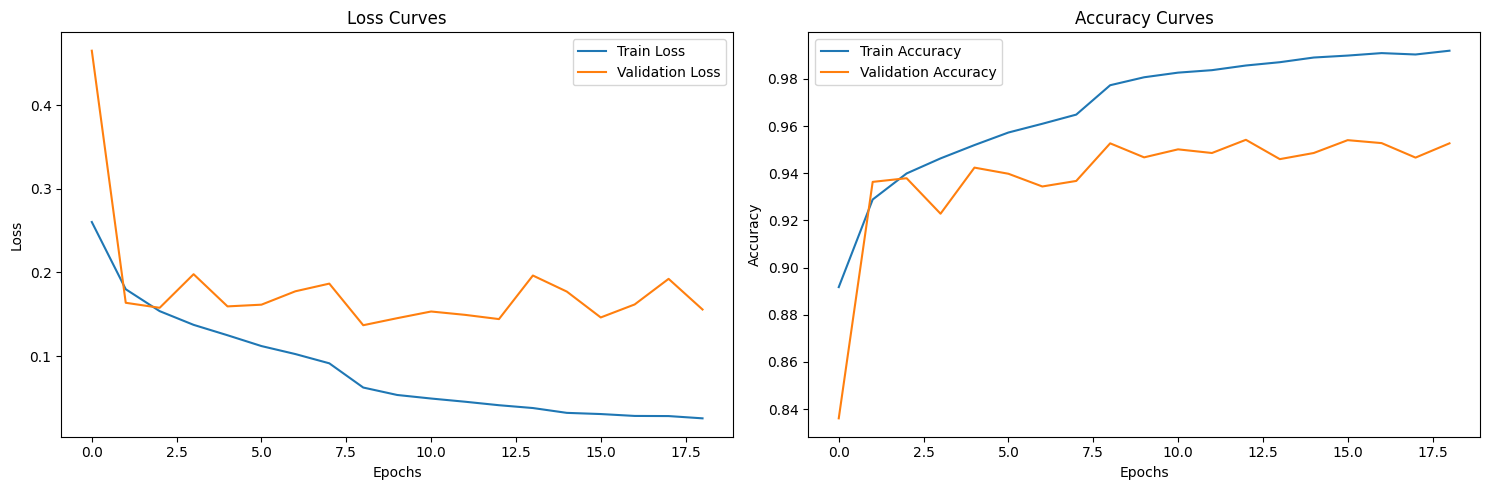

In [24]:
history = history_base

# 학습 곡선 시각화
plt.figure(figsize=(15, 5))

# Loss 곡선
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 곡선
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 1단계: Conv 레이어 그리드 탐색
def grid_search_conv():
    conv_results = []
    conv_layer_options = [1, 2, 3]
    conv_filter_options = [16, 32, 64]

    for num_layers, filter_size in itertools.product(conv_layer_options, conv_filter_options):

        # 모델 생성 (Dense 레이어는 기본값 고정)
        model = build_model(
            num_conv_layers=num_layers,
            conv_filters=filter_size,
            num_dense_layers=1,
            dense_neurons=64,
            dropout_rate=0.3
        )

        # 모델 컴파일
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )

        # 모델 훈련
        history = train_model(
            model,
            train_ds, val_ds,
            train_batches, val_batches,
            epochs=epochs_num,
            batch_size=batch_size
        )

        y_pred = model.predict(test_ds)
        y_pred = np.round(y_pred).flatten()
        test_acc = accuracy_score(y_true, y_pred)

        # 최고 검증 정확도 기록
        best_val_acc = max(history.history['val_accuracy'])
        conv_results.append({
            'conv_layers': num_layers,
            'filters': filter_size,
            'val_accuracy': best_val_acc,
            'test_accuracy': test_acc
        })

    # 결과 분석
    df_conv = pd.DataFrame(conv_results)
    best_conv = df_conv.loc[df_conv['test_accuracy'].idxmax()]
    print("\n[1단계] Conv 레이어 최적화 결과:")
    print(df_conv)
    print(f"\n최적 조합: Conv 층 {best_conv['conv_layers']}개, 필터 {best_conv['filters']}개")

    return best_conv

# 2단계: Dense 레이어 그리드 탐색
def grid_search_dense():
    dense_results = []
    dense_layer_options = [1, 2, 3]
    dense_neuron_options = [32, 64, 128]

    for num_layers, neuron_size in itertools.product(dense_layer_options, dense_neuron_options):

        # 모델 생성 (Conv 레이어는 1단계 최적값 사용)
        model = build_model(
            num_conv_layers=2,
            conv_filters=32,
            num_dense_layers=num_layers,
            dense_neurons=neuron_size,
            dropout_rate=0.3
        )

        # 모델 컴파일
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )

        # 모델 훈련
        history = train_model(
            model,
            train_ds, val_ds,
            train_batches, val_batches,
            epochs=epochs_num,
            batch_size=batch_size
        )

        y_pred = model.predict(test_ds)
        y_pred = np.round(y_pred).flatten()
        test_acc = accuracy_score(y_true, y_pred)

        # 최고 검증 정확도 기록
        best_val_acc = max(history.history['val_accuracy'])
        dense_results.append({
            'dense_layers': num_layers,
            'neurons': neuron_size,
            'val_accuracy': best_val_acc,
            'test_accuracy': test_acc
        })

    # 결과 분석
    df_dense = pd.DataFrame(dense_results)
    best_dense = df_dense.loc[df_dense['test_accuracy'].idxmax()]
    print("\n[2단계] Dense 레이어 최적화 결과:")
    print(df_dense)
    print(f"\n최적 조합: Dense 층 {best_dense['dense_layers']}개, 뉴런 {best_dense['neurons']}개")

    return best_dense


In [28]:
best_conv_params = grid_search_conv()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8233 - loss: 0.3918 - precision_23: 0.8117 - recall_23: 0.8429 - val_accuracy: 0.8640 - val_loss: 0.3262 - val_precision_23: 0.8013 - val_recall_23: 0.9679 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9121 - loss: 0.2180 - precision_23: 0.9104 - recall_23: 0.9136 - val_accuracy: 0.9004 - val_loss: 0.2435 - val_precision_23: 0.9036 - val_recall_23: 0.8964 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9290 - loss: 0.1793 - precision_23: 0.9299 - recall_23: 0.9292 - val_accuracy: 0.9186 - val_loss: 0.2039 - val_precision_23: 0.9039 - val_recall_23: 0.9368 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9392 - loss: 0.1585 - precision_23: 0.9401 - recall_23: 0.9374 - val_accuracy: 0.8993 - val_loss: 0.2570 - val_precision_23: 0.8470 - val_recall_23: 0.9747 - learning_rate: 0.0010
Epoch 5/20
625/6

In [34]:
best_dense_params = grid_search_dense()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8526 - loss: 0.3407 - precision_56: 0.8449 - recall_56: 0.8648 - val_accuracy: 0.9175 - val_loss: 0.2091 - val_precision_56: 0.9299 - val_recall_56: 0.9028 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9232 - loss: 0.1950 - precision_56: 0.9209 - recall_56: 0.9251 - val_accuracy: 0.9043 - val_loss: 0.2451 - val_precision_56: 0.8576 - val_recall_56: 0.9694 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9366 - loss: 0.1632 - precision_56: 0.9360 - recall_56: 0.9373 - val_accuracy: 0.9039 - val_loss: 0.2529 - val_precision_56: 0.8528 - val_recall_56: 0.9760 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9421 - loss: 0.1504 - precision_56: 0.9441 - recall_56: 0.9405 - val_accuracy: 0.9079 - val_loss: 0.2243 - val_precision_56: 0.9755 - val_recall_56: 0.8366 - learning_rate: 0.0010
Epoch 5/20
625/

In [36]:
# 최종 모델 구성
final_model = build_model(
    num_conv_layers=2,
    conv_filters=64,
    num_dense_layers=1,
    dense_neurons=64,
    dropout_rate=0.3
)

# 모델 컴파일 및 훈련
final_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history_final = train_model(
    final_model,
    train_ds, val_ds,
    train_batches, val_batches,
    epochs=epochs_num,
    batch_size=batch_size
)

# 테스트 평가
y_pred_final = final_model.predict(test_ds)
y_pred_final = np.round(y_pred_final).flatten()

print('\n[최종 모델] 테스트 결과')
print(classification_report(y_true, y_pred_final, target_names=['FAKE', 'REAL'], digits=4))

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8633 - loss: 0.3217 - precision_74: 0.8530 - recall_74: 0.8786 - val_accuracy: 0.8608 - val_loss: 0.3660 - val_precision_74: 0.7905 - val_recall_74: 0.9815 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9322 - loss: 0.1742 - precision_74: 0.9311 - recall_74: 0.9326 - val_accuracy: 0.9007 - val_loss: 0.2463 - val_precision_74: 0.8453 - val_recall_74: 0.9806 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9445 - loss: 0.1453 - precision_74: 0.9445 - recall_74: 0.9444 - val_accuracy: 0.7545 - val_loss: 0.5624 - val_precision_74: 0.9932 - val_recall_74: 0.5122 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9523 - loss: 0.1251 - precision_74: 0.9523 - recall_74: 0.9525 - val_accuracy: 0.9406 - val_loss: 0.1604 - val_precision_74: 0.9340 - val_recall_74: 0.9481 - learning_rate: 0.0010
Epoch 5/20
625